### Working with IUCN data in shapefiles

#### just some logging/plotting magic to output in this notebook, nothing to care about.

In [2]:
import logging
root = logging.getLogger()
root.addHandler(logging.StreamHandler())
%matplotlib inline
import pyproj
from functools import partial
from shapely.geometry import shape
from shapely.ops import transform

## 1. Load a shapefile with all turtles data. At this point no data cleaning is done yet.

In [36]:
# download http://bit.ly/1R8pt20 (zipped Turtles shapefiles), and unzip them
from iSDM.species import IUCNSpecies
turtles = IUCNSpecies(ID=10004)
#turtles.load_shapefile('../data/FW_TURTLES/FW_TURTLES.shp')
turtles.load_shapefile('/home/yinonbaron/Downloads/terrestrial_mammals/TERRESTRIAL_MAMMALS.shp')

Enabled Shapely speedups for performance.
Loading data from: /home/yinonbaron/Downloads/terrestrial_mammals/TERRESTRIAL_MAMMALS.shp
The shapefile contains data on 12546 species areas.


#### Show only first 5 species (meta)data, to get an idea of the data structure.

In [10]:
t = turtles.get_data().loc[0,'geometry']

proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),pyproj.Proj(init='epsg:3857'))
#s = shape(turtles.get_data()['geometry'])
s = shape(t)
s_new = transform(proj, s)
projected_area = transform(proj, s).area

projected_area/1e11
data = turtles.get_data()
data.set_index('id_no',inplace=True)
for index in data.index:
    s = shape(data.loc[index,'geometry'])
    s_new = transform(proj, s)
    data.loc[index,'shape_area'] = transform(proj, s).area


In [44]:
import pandas as pd

data.head()

range_data =pd.read_csv('range_data_from_r.csv', index_col=0)
g = turtles.get_data()

name_mapping = g[['id_no','binomial']].drop_duplicates().set_index('id_no')
range_data['binomial'] = name_mapping
range_data

Range_size                       binomial
10004      2.968990e+11             Heteromys anomalus
10005      2.268867e+11            Heteromys australis
10007      1.671570e+11              Heteromys gaumeri
10009      4.792584e+08              Heteromys nelsoni
10010      1.327433e+09            Heteromys oresterus
10032      1.559824e+11         Choeropsis liberiensis
10053      4.247130e+11        Hippocamelus antisensis
10054      1.296764e+11          Hippocamelus bisulcus
10103      1.233077e+12         Hippopotamus amphibius
10107      2.302367e+10             Hipposideros papua
10108      2.190430e+11           Hipposideros ridleyi
10109      2.324234e+12              Hipposideros abae
10110      4.475407e+12           Hipposideros armiger
10111      3.677530e+12              Hipposideros ater
10112      1.635969e+12            Hipposideros beatus
10113      1.584432e+12           Hipposideros bicolor
10114      6.264164e+08         Hipposideros breviceps
10115      6.346905e+12            Hipposideros caffer
10116      2.174841e+11        Hipposideros calcaratus
10117      1.119249e+10      Hipposideros camerunensis
10118      1.964927e+12          Hipposideros cervinus
10119      2.203630e+12        Hipposideros cineraceus
10120      5.131601e+11        Hipposideros commersoni
10121      9.863163e+08         Hipposideros coronatus
10122      1.988090e+09     Hipposideros corynophyllus
101228458  1.225735e+13            Coendou prehensilis
10123      2.684567e+09              Hipposideros coxi
10124      2.405499e+09      Hipposideros crumeniferus
10125      1.352240e+11            Hipposideros curtus
10126      2.331074e+12           Hipposideros cyclops
...                 ...                            ...
97249272   1.635497e+12            Monodelphis glirina
9736       9.041958e+11          Harpiocephalus harpia
9740       1.718655e+11     Harpyionycteris whiteheadi
9759       5.047084e+11              Heimyscus fumosus
9760       3.567150e+12            Helarctos malayanus
9828       2.122615e+12  Heliophobius argenteocinereus
9830       4.714373e+12         Heliosciurus gambianus
9831       1.063837e+12         Heliosciurus mutabilis
9832       3.257009e+11         Heliosciurus punctatus
9833       2.935775e+12      Heliosciurus rufobrachium
9834       1.405809e+11        Heliosciurus ruwenzorii
9835       1.292674e+11         Heliosciurus undulatus
9869       2.913768e+09        Hemibelideus lemuroides
9917       2.096837e+09        Nilgiritragus hylocrius
9918       3.155640e+10           Arabitragus jayakari
9919       1.240079e+11          Hemitragus jemlahicus
9948       1.485089e+13       Herpailurus yagouaroundi
99586593   5.546771e+11              Dermanura watsoni
99688187   3.071399e+10         Pteropus chrysoproctus
99712630   5.103032e+09               Murina harrisoni
9975       4.604301e+11        Hesperoptenus blanfordi
9976       6.861280e+09           Hesperoptenus doriae
9977       8.960496e+06         Hesperoptenus gaskelli
9978       1.051793e+12         Hesperoptenus tickelli
99783878   3.390162e+12           Lophostoma carrikeri
9979       4.440434e+10           Hesperoptenus tomesi
9987       1.349751e+12          Heterocephalus glaber
99890206   9.414389e+11              Ochotona pallasii
99892252   1.799498e+11                 Ochotona opaca
9997       5.937569e+12             Heterohyrax brucei

[5406 rows x 2 columns]

In [145]:
mass_data = pd.read_csv('PanTHERIA_1-0_WR05_Aug2008.csv', sep='\t')
merged_data = mass_data.merge(range_data,how='inner',right_on='binomial',left_on='MSW05_Binomial')

#merged_data[merged_data['binomial'] == 'Camelus ferus']
shai_func = lambda x: (10**(-0.822*np.log10(x) + 1.936))/1e4
shai_real_func = lambda x,y:  10**(1.65-0.53*np.log10(x) + 0.73*np.log10(y/1e4))

filtered_merged_data = merged_data[merged_data['5-1_AdultBodyMass_g'] != -999]
filtered_merged_data['Total mass'] = shai_func(filtered_merged_data['5-1_AdultBodyMass_g'])*filtered_merged_data['5-1_AdultBodyMass_g']*filtered_merged_data['Range_size']
filtered_merged_data.loc[np.argmax(filtered_merged_data['Total mass'])]


merged_data.replace(-999,np.nan,inplace=True)
merged_data['Total mass'] = merged_data['5-1_AdultBodyMass_g']*merged_data['21-1_PopulationDensity_n/km2']*merged_data['Range_size']/1e6
merged_data['Total mass shai'] = shai_func(merged_data['5-1_AdultBodyMass_g'])*merged_data['5-1_AdultBodyMass_g']*merged_data['Range_size']
merged_data['Total mass real shai'] = shai_real_func(merged_data['5-1_AdultBodyMass_g'],merged_data['Range_size'])*merged_data['5-1_AdultBodyMass_g']
merged_data['Total population real shai'] = shai_real_func(merged_data['5-1_AdultBodyMass_g'],merged_data['Range_size'])
y = merged_data.loc[merged_data['Total mass'].sort_values(ascending=False).index]
y2 = merged_data.loc[merged_data['Total mass shai'].sort_values(ascending=False).index]
y3 = merged_data.loc[merged_data['Total mass real shai'].sort_values(ascending=False).index]
y[['MSW05_Binomial','5-1_AdultBodyMass_g','21-1_PopulationDensity_n/km2','Range_size','Total mass']]
y2[['MSW05_Binomial','5-1_AdultBodyMass_g','21-1_PopulationDensity_n/km2','Range_size','Total mass shai']]
y3[['MSW05_Binomial','5-1_AdultBodyMass_g','21-1_PopulationDensity_n/km2','Range_size','Total mass real shai','Total population real shai']]

merged_data['Total mass real shai'].sum()*0.15/1e15

#y3['Total mass real shai'].dropna()
merged_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


MSW05_Order    MSW05_Family    MSW05_Genus  MSW05_Species  \
0           Carnivora         Canidae          Canis        adustus   
1           Carnivora         Canidae          Canis         aureus   
2           Carnivora         Canidae          Canis        latrans   
3           Carnivora         Canidae          Canis          lupus   
4        Artiodactyla         Bovidae            Bos      javanicus   
5            Primates     Pitheciidae     Callicebus        cupreus   
6            Primates     Pitheciidae     Callicebus       discolor   
7            Primates     Pitheciidae     Callicebus   donacophilus   
8            Primates     Pitheciidae     Callicebus         dubius   
9            Primates     Pitheciidae     Callicebus     hoffmannsi   
10           Primates     Pitheciidae     Callicebus        lucifer   
11           Primates     Pitheciidae     Callicebus         lugens   
12           Primates     Pitheciidae     Callicebus         medemi   
13           Primates     Pitheciidae     Callicebus     melanochir   
14           Primates     Pitheciidae     Callicebus       modestus   
15    Didelphimorphia     Didelphidae      Caluromys      derbianus   
16    Didelphimorphia     Didelphidae      Caluromys        lanatus   
17    Didelphimorphia     Didelphidae      Caluromys      philander   
18    Didelphimorphia     Didelphidae  Caluromysiops        irrupta   
19       Artiodactyla         Bovidae            Bos        sauveli   
20       Artiodactyla         Bovidae     Boselaphus   tragocamelus   
21           Rodentia         Muridae     Brachiones    przewalskii   
22          Carnivora         Canidae          Canis      mesomelas   
23          Carnivora         Canidae          Canis       simensis   
24           Rodentia      Spalacidae       Cannomys         badius   
25           Rodentia      Cricetidae       Cansumys          canus   
26       Artiodactyla         Bovidae          Capra      caucasica   
27       Artiodactyla         Bovidae          Capra      falconeri   
28       Artiodactyla         Bovidae          Capra           ibex   
29     Erinaceomorpha     Erinaceidae       Atelerix        algirus   
...               ...             ...            ...            ...   
4654        Carnivora         Canidae         Vulpes     rueppellii   
4655        Carnivora         Canidae         Vulpes          velox   
4656        Carnivora         Canidae         Vulpes         vulpes   
4657        Carnivora         Canidae         Vulpes          zerda   
4658    Diprotodontia    Macropodidae       Wallabia        bicolor   
4659         Rodentia      Cricetidae       Wiedomys   pyrrhorhinos   
4660         Rodentia      Cricetidae    Wilfredomys          oenax   
4661    Diprotodontia   Phalangeridae         Wyulda  squamicaudata   
4662         Rodentia      Cricetidae        Xenomys        nelsoni   
4663         Rodentia         Muridae      Xenuromys       barbatus   
4664         Rodentia         Muridae        Xeromys        myoides   
4665         Rodentia       Sciuridae          Xerus     erythropus   
4666         Rodentia       Sciuridae          Xerus        inauris   
4667         Rodentia       Sciuridae          Xerus       princeps   
4668         Rodentia       Sciuridae          Xerus        rutilus   
4669      Monotremata  Tachyglossidae      Zaglossus  attenboroughi   
4670      Monotremata  Tachyglossidae      Zaglossus        bartoni   
4671         Rodentia       Dipodidae          Zapus      hudsonius   
4672         Rodentia       Dipodidae          Zapus       princeps   
4673         Rodentia       Dipodidae          Zapus     trinotatus   
4674         Rodentia         Muridae      Zelotomys   hildegardeae   
4675         Rodentia         Muridae      Zelotomys       woosnami   
4676         Rodentia    Anomaluridae     Zenkerella       insignis   
4677         Rodentia      Cricetidae   Zygodontomys     brevicauda   
4678         Rodentia      Criceti

In [146]:
y4 = y3[y3['Total mass real shai'] >np.percentile(y3['Total mass real shai'].dropna(),98)]
y4['Total mass real shai'].sum()*0.15/1e15
#y4.to_excel('top_mammals.xlsx')
y4

MSW05_Order     MSW05_Family    MSW05_Genus   MSW05_Species  \
124   Perissodactyla   Rhinocerotidae  Ceratotherium           simum   
4258    Artiodactyla         Cervidae          Alces           alces   
4610       Carnivora          Ursidae          Ursus          arctos   
4611       Carnivora          Ursidae          Ursus       maritimus   
1915     Proboscidea     Elephantidae      Loxodonta        africana   
393   Perissodactyla   Rhinocerotidae        Diceros        bicornis   
4145    Artiodactyla          Bovidae       Syncerus          caffer   
4107    Artiodactyla           Suidae            Sus          scrofa   
3          Carnivora          Canidae          Canis           lupus   
2846       Carnivora          Felidae       Panthera          pardus   
3495    Artiodactyla         Cervidae       Rangifer        tarandus   
4053  Perissodactyla        Tapiridae        Tapirus      terrestris   
4609       Carnivora          Ursidae          Ursus      americanus   
3438       Carnivora          Felidae           Puma        concolor   
1635    Artiodactyla          Bovidae          Kobus  ellipsiprymnus   
2781   Tubulidentata  Orycteropodidae    Orycteropus            afer   
2764    Artiodactyla         Cervidae     Odocoileus     virginianus   
1475       Carnivora        Hyaenidae         Hyaena          hyaena   
3441    Artiodactyla         Cervidae           Rusa        unicolor   
870        Carnivora        Hyaenidae        Crocuta         crocuta   
1461    Artiodactyla          Bovidae    Hippotragus         equinus   
4656       Carnivora          Canidae         Vulpes          vulpes   
4036    Artiodactyla          Bovidae    Tragelaphus    strepsiceros   
4257    Artiodactyla          Bovidae     Alcelaphus      buselaphus   
3050    Artiodactyla           Suidae   Phacochoerus       africanus   
4612       Carnivora          Ursidae          Ursus      thibetanus   
1483        Rodentia         Caviidae   Hydrochoerus    hydrochaeris   
2845       Carnivora          Felidae       Panthera            onca   
1299    Artiodactyla       Giraffidae        Giraffa  camelopardalis   
1932       Carnivora          Felidae           Lynx            lynx   
...              ...              ...            ...             ...   
4442    Artiodactyla      Tayassuidae        Tayassu          pecari   
153     Artiodactyla         Cervidae         Cervus         elaphus   
1221       Carnivora       Mustelidae           Gulo            gulo   
1693       Carnivora       Mustelidae      Mellivora        capensis   
1          Carnivora          Canidae          Canis          aureus   
2275          Pilosa  Myrmecophagidae   Myrmecophaga      tridactyla   
426      Proboscidea     Elephantidae        Elephas         maximus   
2911    Artiodactyla      Tayassuidae         Pecari          tajacu   
2763    Artiodactyla         Cervidae     Odocoileus        hemionus   
1919       Carnivora       Mustelidae          Lutra           lutra   
288   Perissodactyla          Equidae          Equus          quagga   
1462    Artiodactyla          Bovidae    Hippotragus           niger   
656         Rodentia       Castoridae         Castor      canadensis   
2844       Carnivora          Felidae       Panthera             leo   
823     Artiodactyla          Bovidae   Connochaetes        taurinus   
3295    Artiodactyla           Suidae  Potamochoerus        larvatus   
341     Artiodactyla         Cervidae    Blastocerus      dichotomus   
120     Artiodactyla          Bovidae    Cephalophus     silvicultor   
641        Carnivora          Felidae        Caracal         caracal   
2          Carnivora          Canidae          Canis         latrans   
4549    Artiodactyla          Bovidae    Tragelaphus       eurycerus   
4112    Artiodactyla          Bovidae     Sylvicapra         grimmia   
4348       Carnivora       Mustelidae          Aonyx        capensis   
1257       Carnivora          Felidae          Fe

In [96]:
shai_func(4820)*7.2e13/1e


575264840.13223791

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


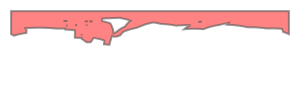

In [17]:
import numpy as np
data.loc[np.argmax(data['shape_area']),'geometry']

In [13]:
data[['shape_area','binomial']].to_csv('range_data2.csv')

In [4]:
turtles.get_data().columns # all the columns available per species geometry

Index(['binomial', 'category', 'citation', 'class_name', 'compiler',
       'dist_comm', 'family_nam', 'genus_name', 'geometry', 'id_no', 'island',
       'kingdom_na', 'legend', 'order_name', 'origin', 'phylum_nam',
       'presence', 'seasonal', 'shape_area', 'shape_leng', 'source',
       'species_na', 'subpop', 'subspecies', 'tax_comm', 'year'],
      dtype='object')

In [5]:
turtles.source.name

'IUCN'

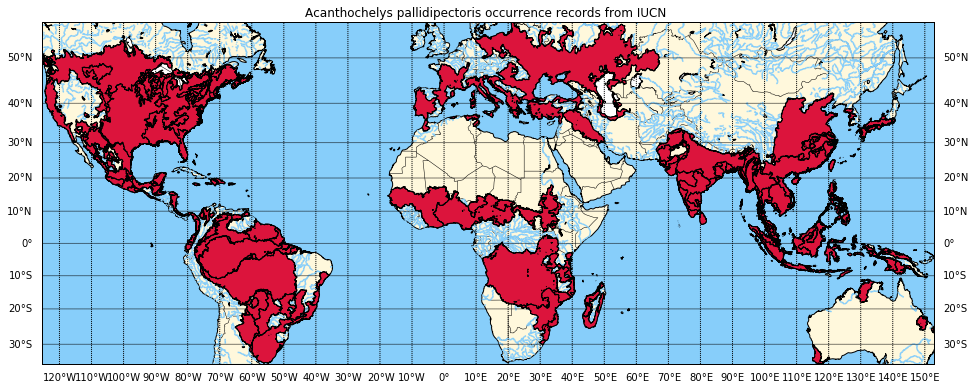

In [10]:
# WARNING! many shapefiles to plot for 181 species! You may want to skip this line if your PC is not strong! :P
turtles.plot_species_occurrence()

## 2. Filter species by the name given above

In [6]:
turtles.find_species_occurrences()

Loaded species: ['Acanthochelys pallidipectoris'] 


binomial category citation class_name compiler  \
138  Acanthochelys pallidipectoris       VU      CRF   REPTILIA   Rhodin   

    dist_comm family_nam     genus_name  \
138      None   CHELIDAE  Acanthochelys   

                                              geometry  id_no   ...    \
138  POLYGON ((-59.20001220703125 -28.0374755859375...   75.0   ...     

    presence seasonal shape_area shape_leng  source       species_na  subpop  \
138      1.0      1.0  36.632836  54.770042   CBFTT  pallidipectoris    None   

     subspecies  tax_comm    year  
138        None      None  2013.0  

[1 rows x 26 columns]

In [7]:
turtles.get_data() # datatype: geopandas.geodataframe.GeoDataFrame

binomial category citation class_name compiler  \
138  Acanthochelys pallidipectoris       VU      CRF   REPTILIA   Rhodin   

    dist_comm family_nam     genus_name  \
138      None   CHELIDAE  Acanthochelys   

                                              geometry  id_no   ...    \
138  POLYGON ((-59.20001220703125 -28.0374755859375...   75.0   ...     

    presence seasonal shape_area shape_leng  source       species_na  subpop  \
138      1.0      1.0  36.632836  54.770042   CBFTT  pallidipectoris    None   

     subspecies  tax_comm    year  
138        None      None  2013.0  

[1 rows x 26 columns]

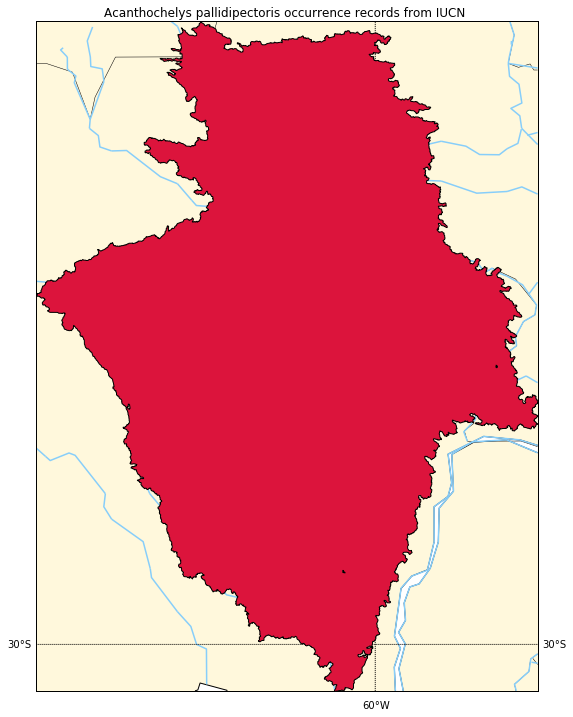

In [8]:
# Now plot the filtered selection
turtles.plot_species_occurrence()

In [9]:
turtles.save_data() # serialize all the current data to a pickle file, so it can be loaded later on

Saved data: /Users/daniela/git/iSDM/notebooks/Acanthochelys pallidipectoris75.pkl 
Type of data: <class 'geopandas.geodataframe.GeoDataFrame'> 


In [10]:
turtles.load_data()

Loading data from: /Users/daniela/git/iSDM/notebooks/Acanthochelys pallidipectoris75.pkl
Succesfully loaded previously saved data.


binomial category citation class_name compiler  \
138  Acanthochelys pallidipectoris       VU      CRF   REPTILIA   Rhodin   

    dist_comm family_nam     genus_name  \
138      None   CHELIDAE  Acanthochelys   

                                              geometry  id_no   ...    \
138  POLYGON ((-59.20001220703125 -28.0374755859375...   75.0   ...     

    presence seasonal shape_area shape_leng  source       species_na  subpop  \
138      1.0      1.0  36.632836  54.770042   CBFTT  pallidipectoris    None   

     subspecies  tax_comm    year  
138        None      None  2013.0  

[1 rows x 26 columns]

In [11]:
turtles.ID # derived from "id_no" column. It's a sort of unique ID per species

75

## 3. Plot geometry

#### Plot the shapefile data, and a convex hull. GeoPandas objects also know how to plot themselves directly.

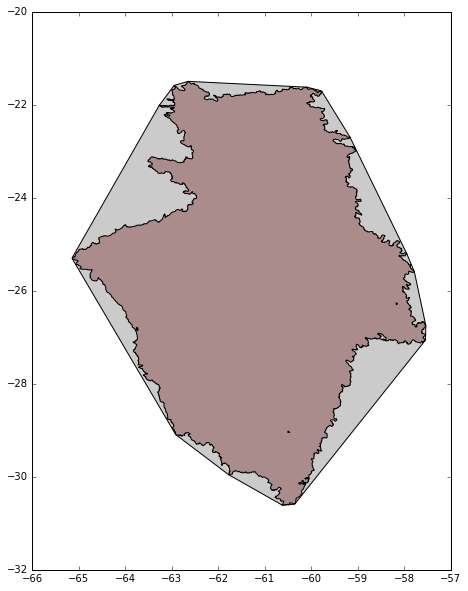

In [12]:
ax = turtles.get_data().plot(figsize=(10,10))
turtles.data_full.geometry.convex_hull.plot(ax=ax)

#### Let's put a buffer around the data, and plot that

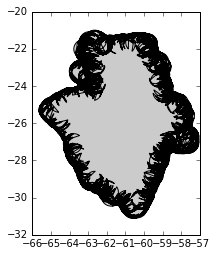

In [13]:
with_buffer = turtles.get_data().geometry.buffer(0.5)
with_buffer.plot() # hmm, now the buffer behaves differently

#### The currently filtered shape data can be saved. If overwrite=True, the shapefile it was loaded from, will be overwritten. Otherwise you can provide a new shape_file as an argument.

In [14]:
turtles.save_shapefile(full_name="./TURTLES_FILTERED.shp")

Saved data: ./TURTLES_FILTERED.shp 


## 4. Sample pseudo-absence points around the geometry 

In [15]:
pseudo_absence = turtles.random_pseudo_absence_points(buffer_distance=1.5, count=200)

Buffered geometry valid. Now creating a buffer difference from which to draw random points
Creating random points ... 


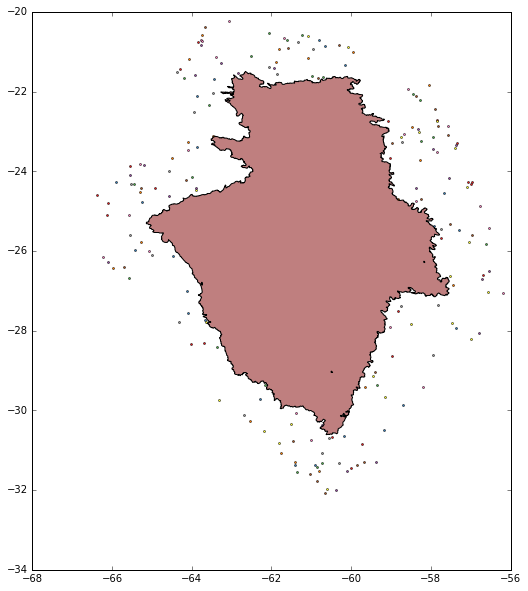

In [16]:
#import matplotlib.pyplot as plt
#plt.figure(figsize=(15,15))
ax = pseudo_absence.plot(figsize=(10,10))
turtles.get_data().plot(ax=ax)

#### This is what is actually happening behind the scenes to create a geometry for drawing points from

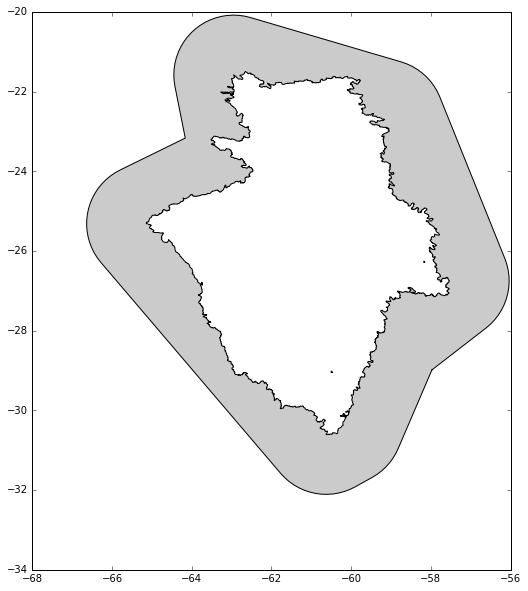

In [17]:
# 1. Make simplified buffer around the geometry
simplified_buffer = turtles.get_data().geometry.buffer(0).simplify(1,True).buffer(1.5)
# 2. Make a difference of the above area, with the original one
buffer_difference = simplified_buffer.geometry.difference(turtles.get_data().geometry.buffer(0))
# 3. Randomly generate points in simplified_buffer's envelope until you reach <count> number of points belonging to this area
buffer_difference.plot(figsize=(10,10))

There are more complicated geometries (possibly with multiple polygons and "invalid"). Operations like intersection or union are problematic for such geometries, as they can throw errors. For example:

Loading data from: ../data/filtered_turtles_again.shp
The shapefile contains data on 1 species.


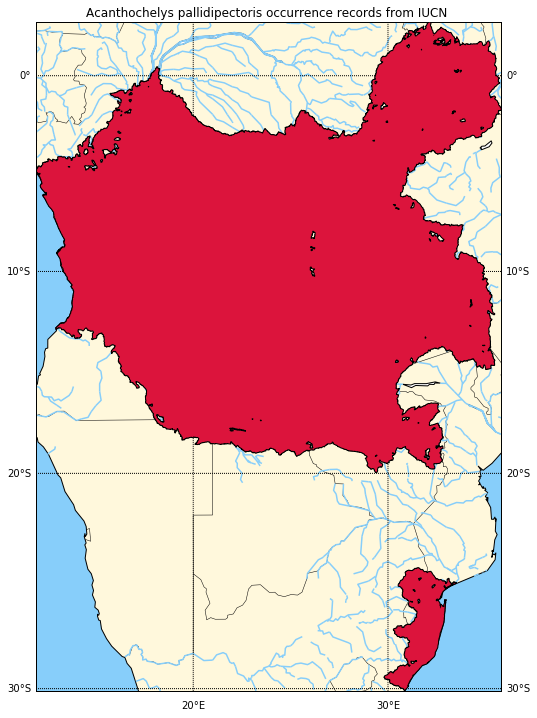

In [18]:
turtles.load_shapefile("../data/filtered_turtles_again.shp")
turtles.plot_species_occurrence()

For them the process of creating a buffer region is a bit more involved, as simplifications must be made. **Note that this is done automatically behind the scenes.** We show the inner-process just to get an idea of the area from which random points are drawn. In this case, the area to draw points from, would look like this:

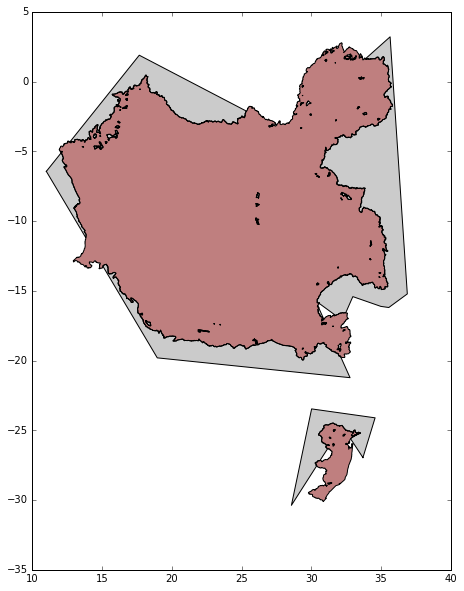

In [19]:
simplified_buffer = turtles.get_data().geometry.buffer(0).simplify(1,True).buffer(1.5)
# this would throw an exception, so we must simplify it further
# buffer_difference = simplified_buffer.geometry.difference(turtles.get_data().geometry.buffer(0))
simplified_buffer = simplified_buffer.simplify(4, True) 
buffer_difference = simplified_buffer.geometry.difference(turtles.get_data().geometry.buffer(0))
ax = buffer_difference.plot(figsize=(10,10))
turtles.get_data().plot(ax=ax)

In practise, all you need to do is, again, only the following:

In [20]:
pseudo_absence = turtles.random_pseudo_absence_points(buffer_distance=1.5, count=200)

Self-intersection at or near point 33.767489061418452 -15.693063020979068
Self-intersection at or near point 33.767489061418452 -15.693063020979068
Buffered geometry is invalid, trying to simplify it using tolerance = 1
Self-intersection at or near point 33.767489061418452 -15.693063020979068
Self-intersection at or near point 33.767489061418452 -15.693063020979068
Buffered geometry is invalid, trying to simplify it using tolerance = 2
Self-intersection at or near point 33.767489061418452 -15.693063020979068
Self-intersection at or near point 33.767489061418452 -15.693063020979068
Buffered geometry is invalid, trying to simplify it using tolerance = 3
Self-intersection at or near point 33.767489061418452 -15.693063020979068
Self-intersection at or near point 33.767489061418452 -15.693063020979068
Buffered geometry is invalid, trying to simplify it using tolerance = 4
Buffered geometry valid. Now creating a buffer difference from which to draw random points
Creating random points ... 


Let's plot them together, the original area and the random points

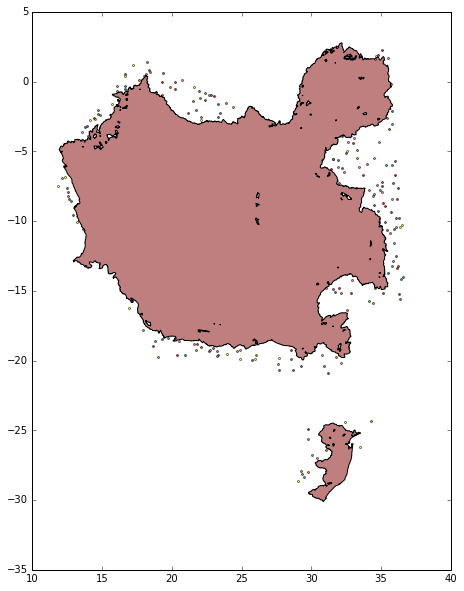

In [21]:
ax = pseudo_absence.plot(figsize=(10,10))
turtles.get_data().plot(ax=ax)

## 5. Rasterize

#### Rasterize the data: we need a target raster_file to save it to, and a resolution.

In [22]:
turtles.rasterize(raster_file='./turtles.tif', pixel_size=0.5, all_touched=True)

RASTERIO: Data rasterized into file ./turtles.tif 
RASTERIO: Resolution: x_res=47 y_res=65


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

#### Or at some point later, if you want to load the raster file

In [23]:
turtles_raster_data = turtles.load_raster_data(raster_file='./turtles.tif')

Loaded raster data from ./turtles.tif 
Driver name: GTiff 
Resolution: x_res=47 y_res=65.
Coordinate reference system: {'init': 'epsg:4326'} 
Affine transformation: (11.92498779296875, 0.5, 0.0, 2.779296875, 0.0, -0.5) 
Number of layers: 1 


In [24]:
turtles_raster_data

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [25]:
turtles_raster_data.shape # 1 layer(band), resolution

(1, 65, 47)

#### A simple plot of the raster data

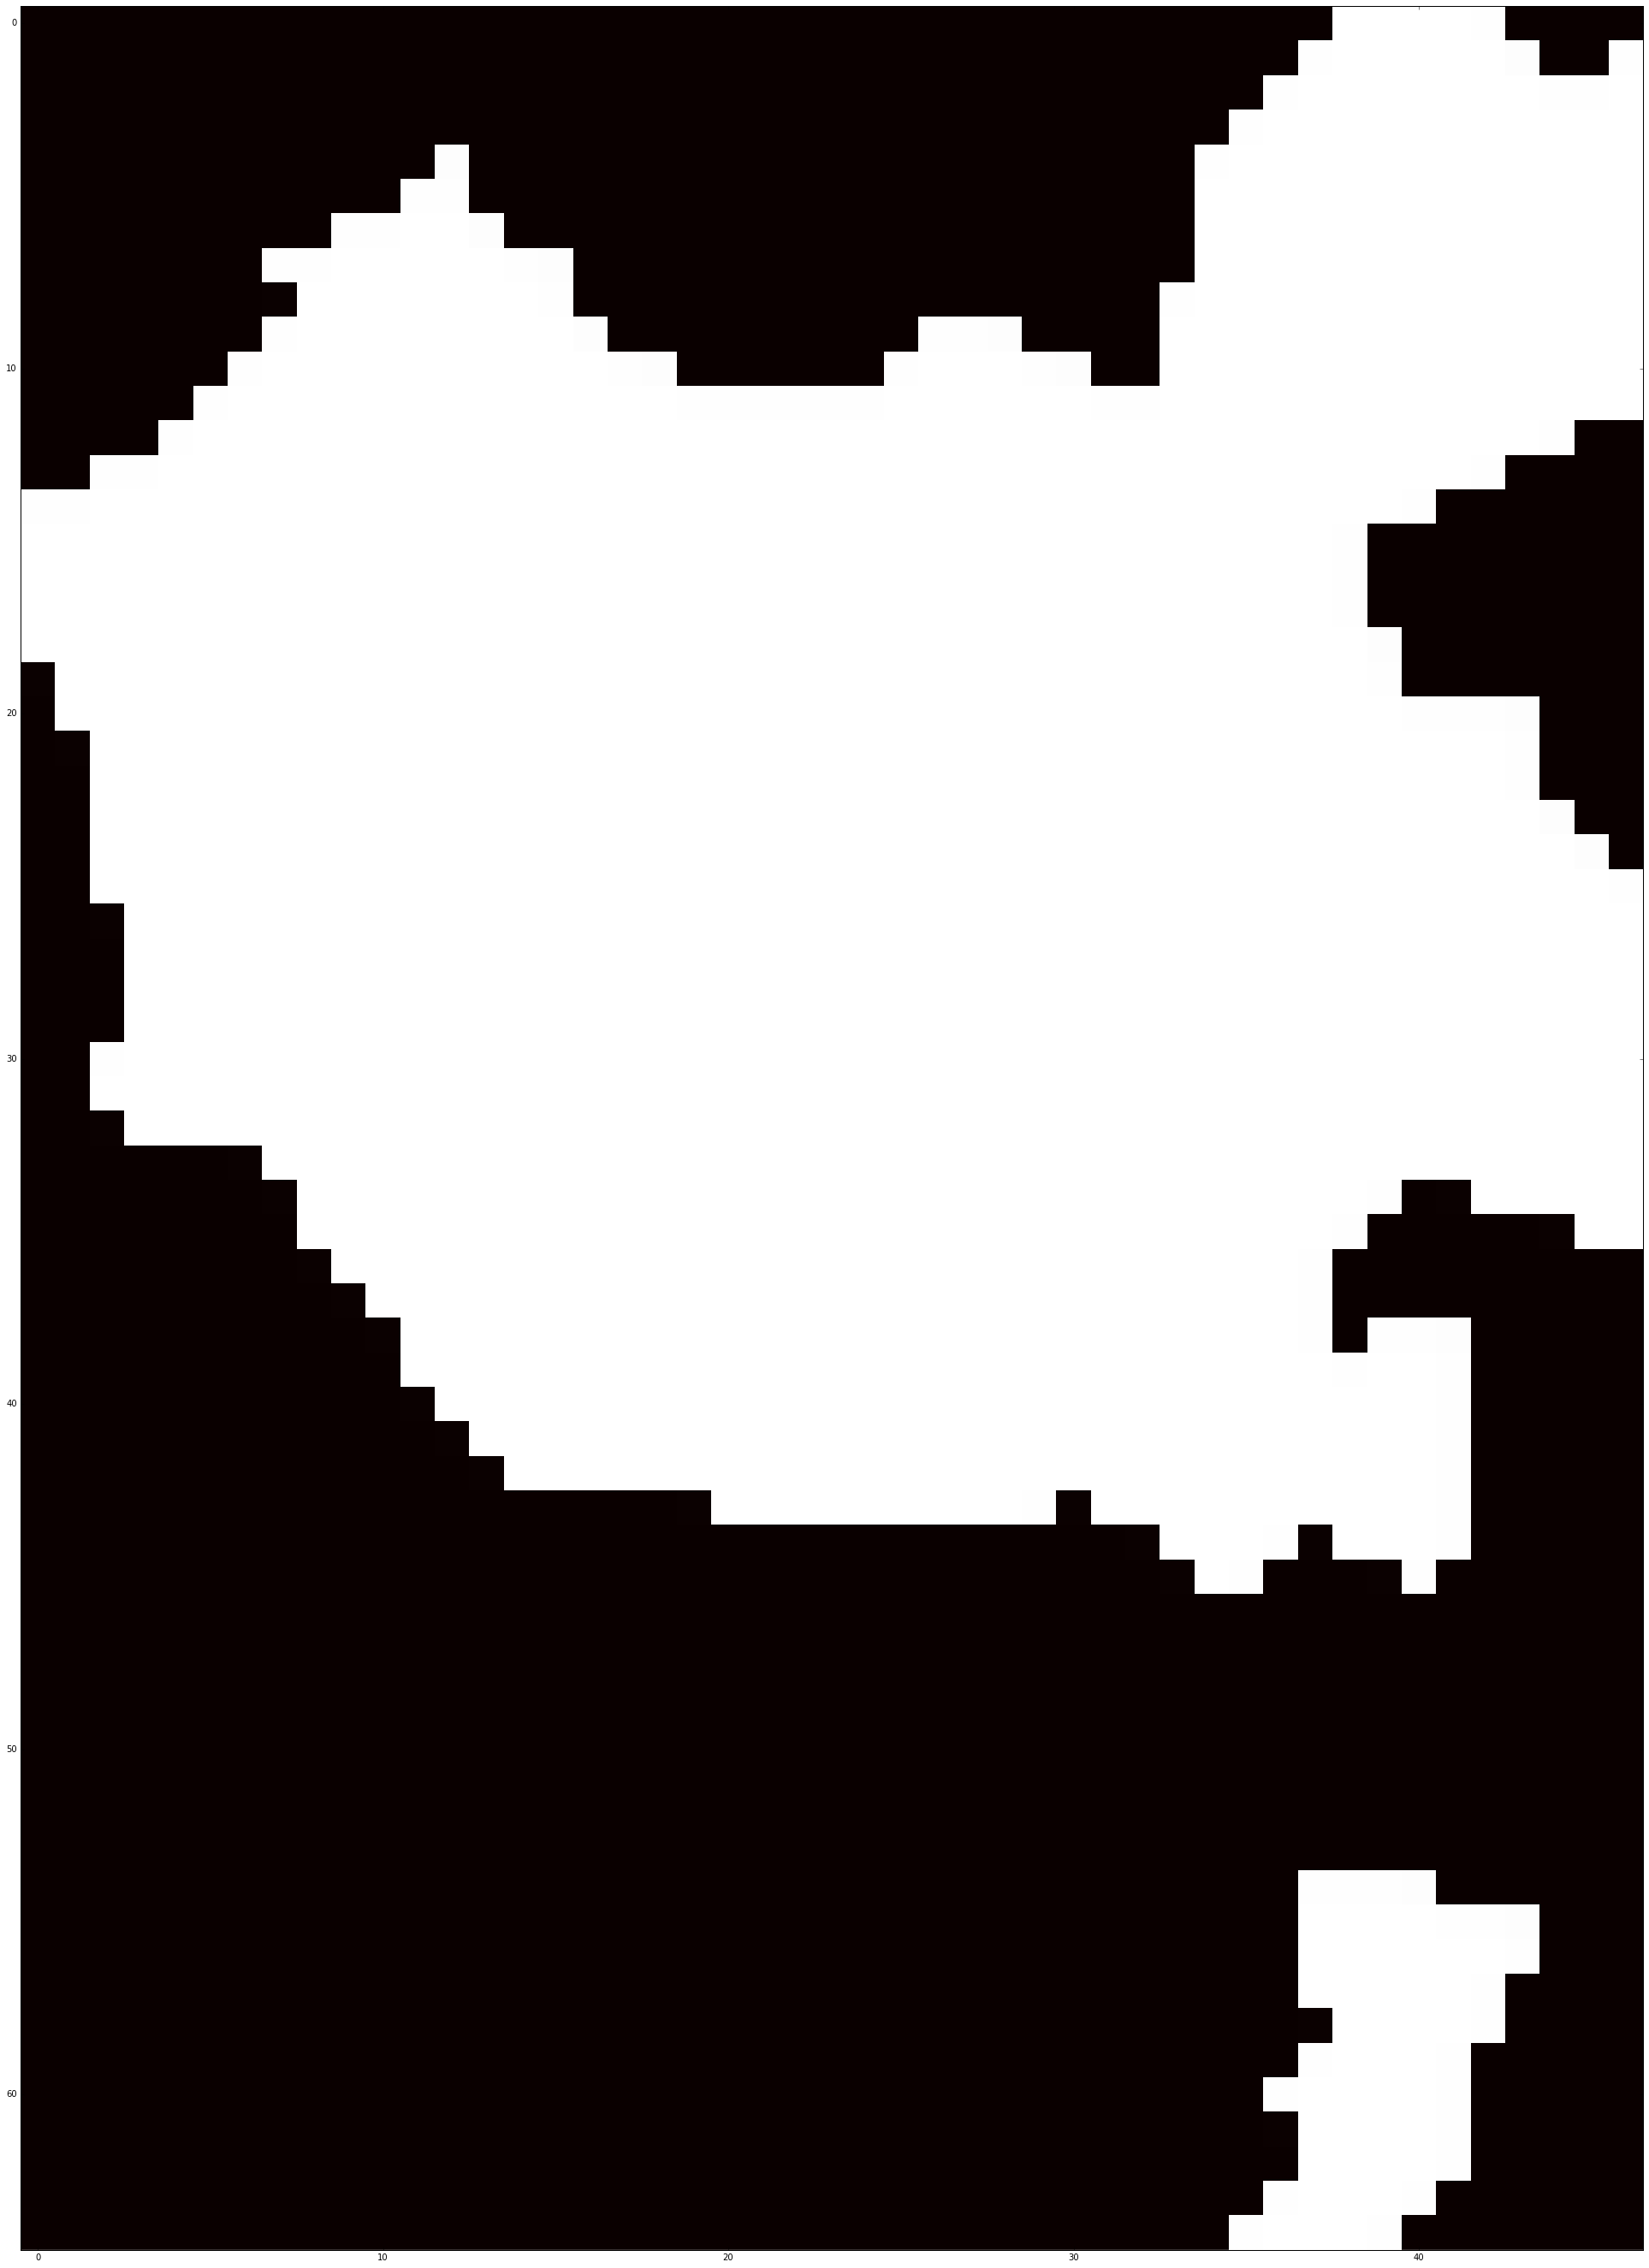

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=turtles_raster_data.shape[1:]) # careful with big images!
plt.imshow(turtles_raster_data[0], cmap="hot", interpolation="none") # the first band has index 0

#### Rasterize with more options

In [27]:
result = turtles.rasterize(raster_file='./turtles.tif', pixel_size=0.5, all_touched=False, no_data_value=254, default_value=5) # all_touched=False now

RASTERIO: Data rasterized into file ./turtles.tif 
RASTERIO: Resolution: x_res=47 y_res=65


In [28]:
result

array([[254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ...,   5,   5,   5],
       ..., 
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254]], dtype=uint8)

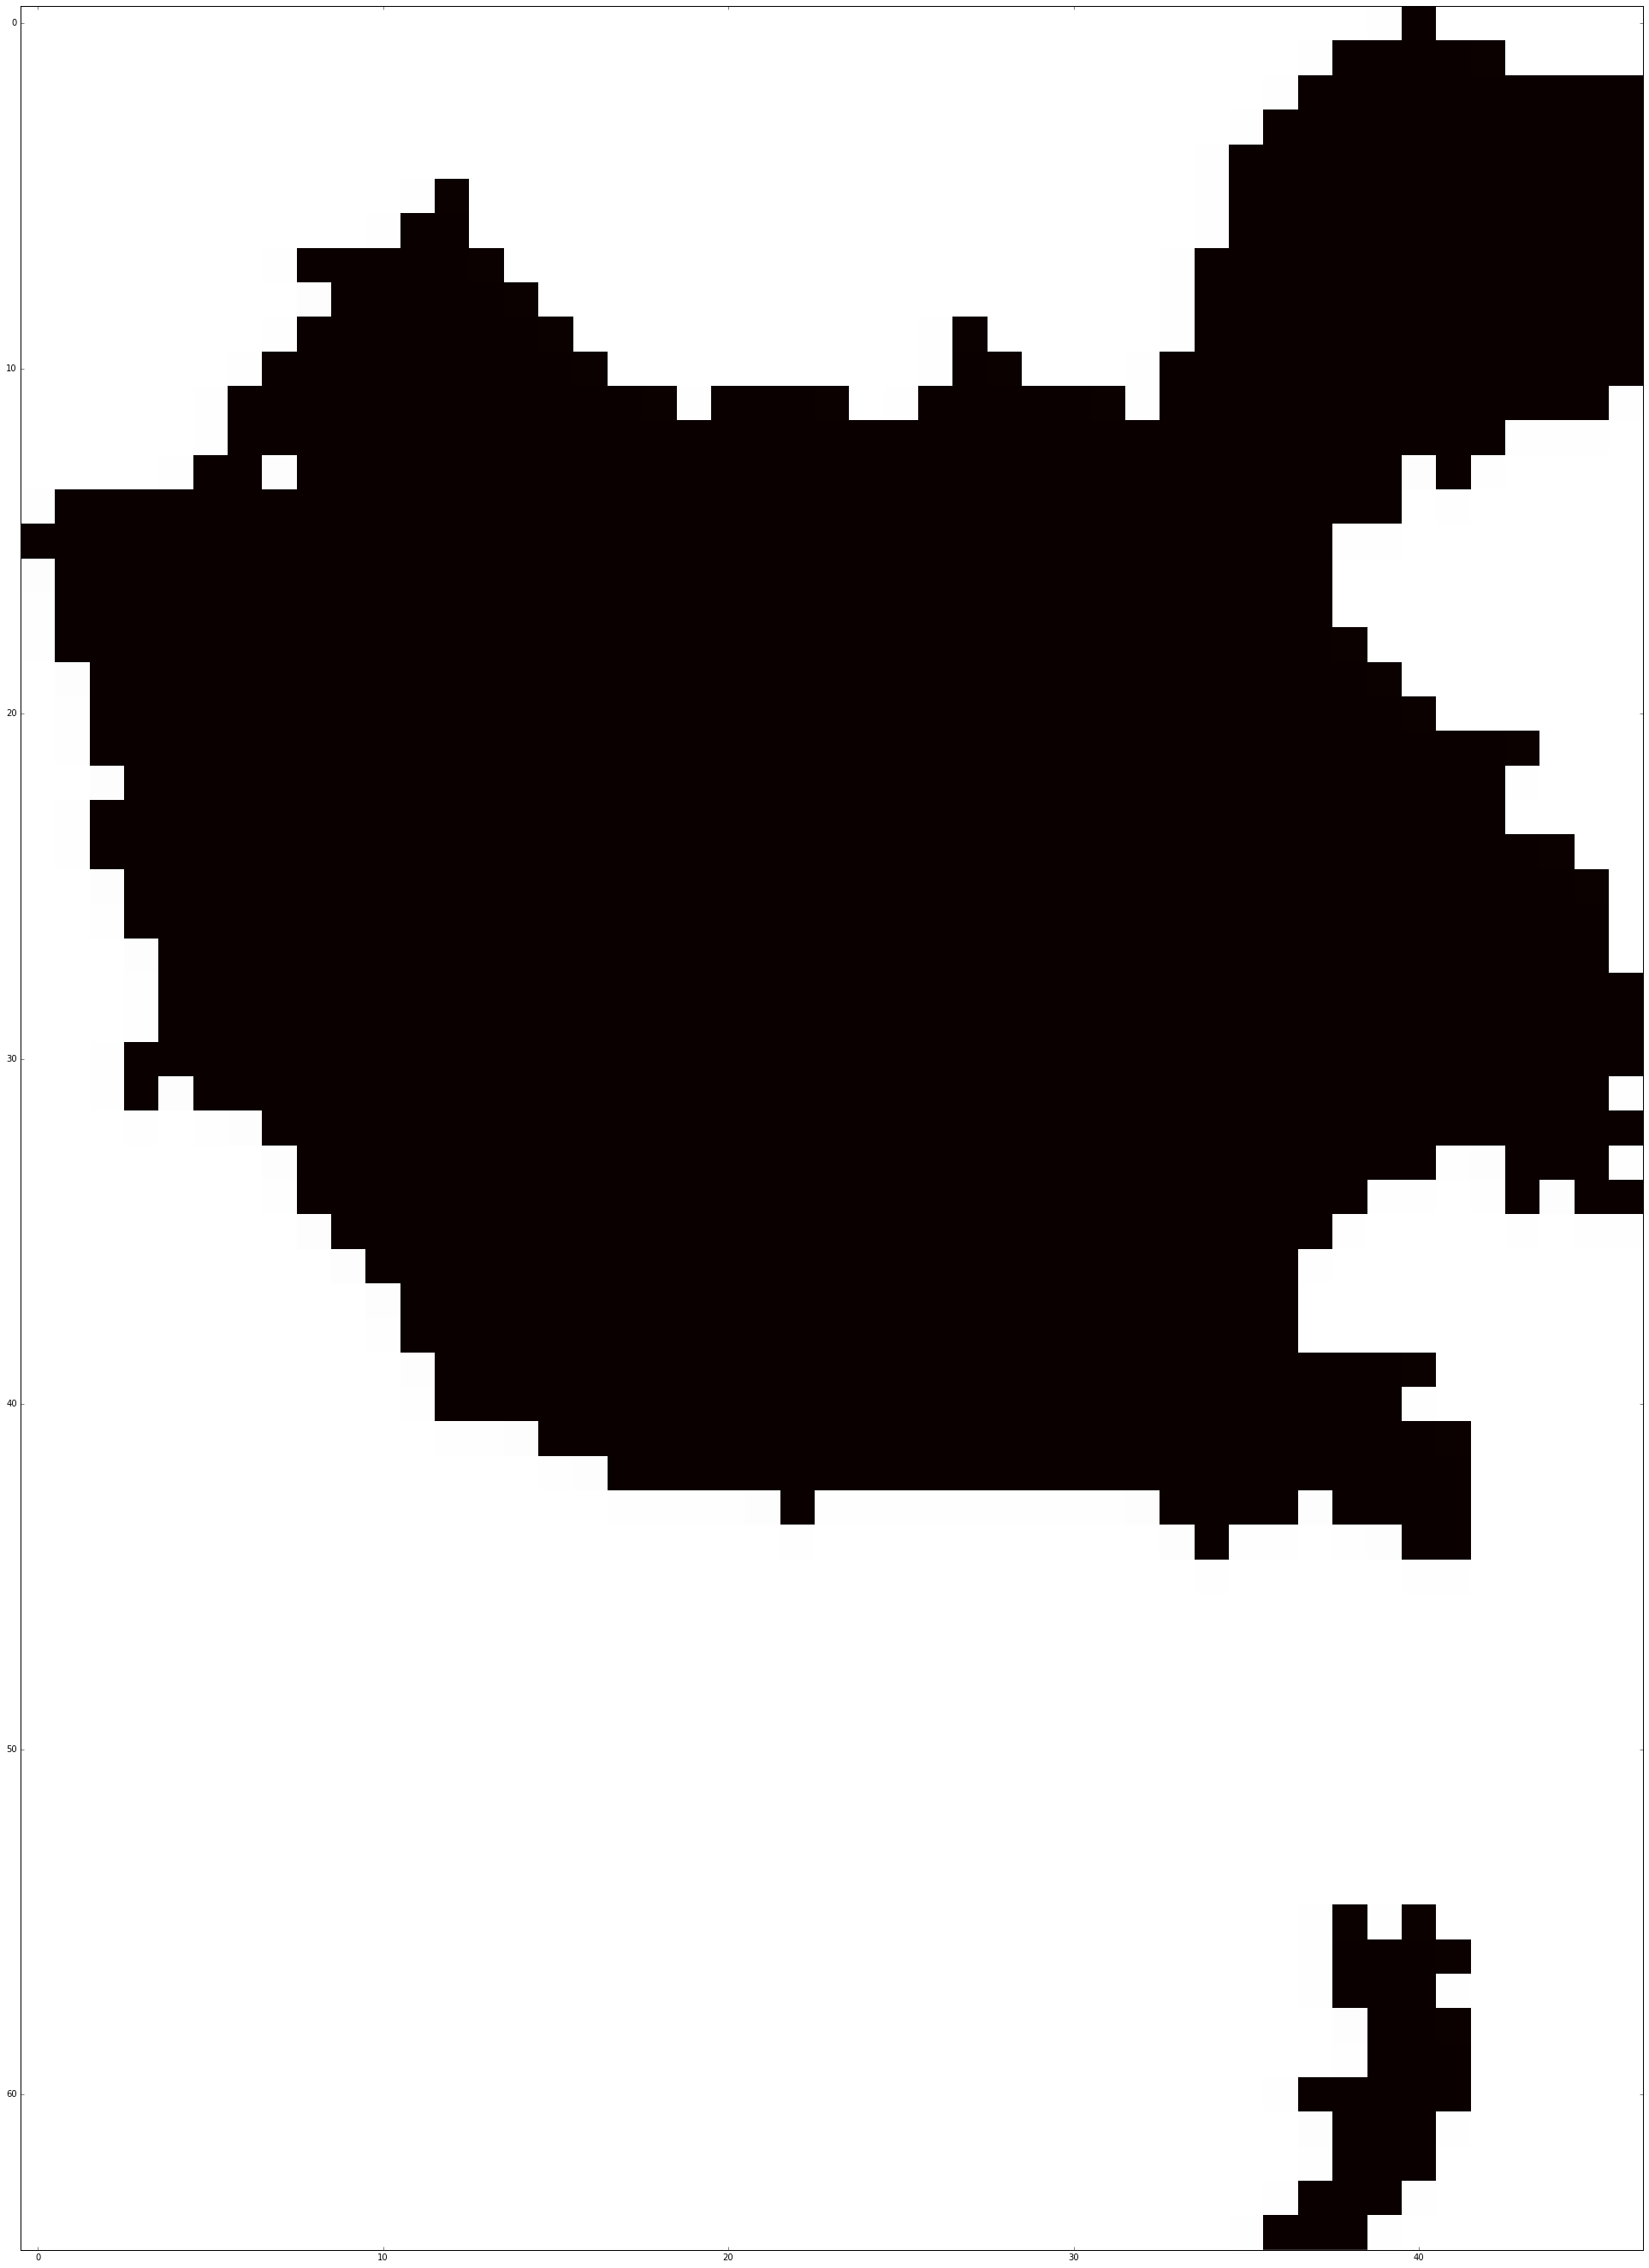

In [29]:
plt.figure(figsize=result.shape) # careful with big images!
plt.imshow(result, cmap="hot", interpolation="none")